In [2]:
import networkx as nx
from networkx.algorithms import tree
from tools import dependency, sentence_attentions
from tools.dependency_converter import DependencyConverter
from sklearn.metrics import confusion_matrix

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import numpy as np

from itertools import cycle, islice

from tqdm import tqdm

from collections import defaultdict, namedtuple
import pandas as pd
%matplotlib inline

In [3]:
dev = True
if dev:
    attention_file = '../BertAA/BertAA-dev/attentions.npz'
    token_file = '../BertAA/BertAA-dev/source.txt'
    conllu_file_name = '../graph-extraction/endev-conv.conllu'
    no_softmax = False
else:
    attention_file = '../BertAA/attentions.npz'
    token_file = '../BertAA/source.txt'
    conllu_file_name = '../data/entest-conv.conllu'
    no_softmax = True
    
conllu_train_file = '../graph-extraction/entrain-conv.conllu'
    

In [4]:
maxlen = 1000

fontsize=8

#this is necessary in this case
eos =True

dependency.define_labels(True)

dependency_rels = dependency.read_conllu_labeled(conllu_file_name)


dependency_rels = [DependencyConverter(sent_rel).convert(return_root=True) for sent_rel in dependency_rels]

with open(token_file) as tokens_file:
    tokens_loaded = [l.split() for l in tokens_file]
    
attentions_loaded = np.load(attention_file)
sentences_count = 1000
layers_count = attentions_loaded['arr_0'].shape[0]
heads_count = attentions_loaded['arr_0'].shape[1]

tokens_grouped, common_tokens = dependency.group_wordpieces(tokens_loaded, conllu_file_name)

## Multigraphs

In [5]:
all_pos = set()
for sent_rels in dependency_rels:
    for dep, head, label, pos in sent_rels:
        all_pos.add(pos)

In [6]:
def pos_dict():
    all_pos = {'ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN','NUM',
    'PART','PRON','PROPN','PUNCT','SCONJ','SYM','VERB','X'}
    
    res_dict = dict()
    for pos1 in all_pos:
        for pos2 in all_pos:
            res_dict[(pos1,pos2)] = 0
    return res_dict

In [7]:
pos_frame = dependency.conllu2freq_frame(conllu_train_file )
RelData= namedtuple('RelData','layers heads transpose d2p')

In [109]:


relation_rules = {#'nsubj': RelData([4,7,8], [10, 11, 10], False, False),
                  'subject-d2p': RelData([5, 7, 7, 7, 1, 0],[9, 2, 1, 8, 6, 8], False, True),
                  'object-d2p': RelData([7, 6, 3, 6, 4, 6, 5],[ 9,  9, 11, 10,  6,  3,  3], False, True),
                  'adj-modifier-d2p': RelData([3, 7, 6, 5, 8, 0, 2], [ 9, 10,  5,  7,  5,  8, 11], True, True),
                  'auxiliary-d2p': RelData([3, 7, 8, 5, 4, 7, 0],[ 9,  6,  5,  0,  5, 10,  8], True,True),
                  'determiner-d2p': RelData([7, 3, 4, 8], [10,  9,  5, 10], True, True)#,
                  #'all': RelData([3, 7, 6, 8, 4, 3, 5, 0, 0], [ 9, 10,  5,  5,  5, 10,  0,  8, 11], True, True )
                 }




In [28]:
relation_rules = {'subject-d2p': RelData([7, 6, 5, 5, 1, 7, 5, 7, 4],[ 2,  6,  9,  0,  6,  1, 11,  8, 11], False, True),
                  'object-d2p': RelData([6, 3, 6],[ 9, 11, 10], False, True),
                  'adj-modifier-d2p': RelData([3, 7, 4, 5],[9, 2, 5, 0], True, True),
                  'auxiliary-d2p': RelData([7, 3, 5, 4, 1, 1],[ 2,  9,  9, 11,  6,  1], True,True),
                  'determiner-d2p': RelData([7, 3, 4],[10,  9,  5], True, True),
                  'all-d2p': RelData([6, 7, 3, 8, 7, 6, 1, 9, 5],[ 6,  2,  9,  5,  6,  5,  6,  3, 11], True, True )
                 }


In [342]:
relation_rules  = {'adj-clause-p2d': RelData([3, 4, 7, 6, 5, 7], [3, 5, 6, 6, 9, 10],False, False),
        'adj-modifier-p2d': RelData([7, 0, 5, 6], [4, 3, 10, 4],False, False),
        'adv-clause-p2d': RelData([5, 3, 4, 5, 1], [8, 3, 8, 11, 5],False, False),
        'adv-modifier-p2d': RelData([7, 5, 6, 4, 9, 4], [7, 1, 9, 7, 3, 10],False, False),
        'all-p2d': RelData([1, 3, 6, 7, 0, 4, 7, 9], [4, 5, 11, 4, 2, 7, 7, 3],False, False),
        'apposition-p2d': RelData([3], [3],False, False),
        'auxiliary-p2d': RelData([7, 6, 1, 8, 1, 9, 8], [3, 2, 10, 11, 6, 4, 4],False, False),
        'clausal subject-p2d': RelData([7, 7], [1, 10],False, False),
        'clausal-p2d': RelData([5, 7, 7, 7, 4, 3, 5, 0, 6, 1], [8, 10, 1, 6, 5, 3, 11, 8, 6, 5],False, False),
        'compound-p2d': RelData([3, 1, 0], [5, 4, 3],False, False),
        'conjunct-p2d': RelData([5, 9, 7, 3, 10, 4, 11], [5, 6, 8, 3, 5, 8, 8],False, False),
        'determiner-p2d': RelData([0, 6, 2, 6, 1], [3, 9, 1, 3, 4],False, False),
        'i object-p2d': RelData([3], [9],False, False),
        'noun-modifier-p2d': RelData([4, 5, 3, 3, 5], [5, 0, 3, 9, 9],False, False),
        'num-modifier-p2d': RelData([7, 4, 0, 6, 5], [11, 7, 2, 9, 9],False, False),
        'object-p2d': RelData([3, 5, 5, 7], [9, 0, 9, 10],False, False),
        'other-p2d': RelData([8, 6, 9, 5, 1, 7, 0, 3, 1], [6, 9, 3, 6, 4, 7, 2, 5, 10],False, False),
        'punctuation-p2d': RelData([5, 6], [10, 11],False, False),
        'subject-p2d': RelData([7, 4, 6], [4, 10, 4],False, False)}


In [340]:
relation_rules  = {'adj-clause-d2p': RelData([6, 6, 3, 0, 7], [9, 2, 11, 3, 9],False, True),
    'adj-modifier-d2p': RelData([3, 7, 4, 5], [9, 2, 5, 0],False, True),
    'adv-clause-d2p': RelData([6, 5, 4, 1, 8, 4, 3], [2, 3, 10, 10, 4, 9, 11],False, True),
    'adv-modifier-d2p': RelData([5, 6, 7, 3, 5, 4, 10, 6], [9, 6, 6, 9, 0, 5, 10, 3],False, True),
    'all-d2p': RelData([6, 7, 3, 8, 7, 6, 1, 9, 5], [6, 2, 9, 5, 6, 5, 6, 3, 11],False, True),
    'apposition-d2p': RelData([4, 3], [10, 11],False, True),
    'auxiliary-d2p': RelData([7, 3, 5, 4, 1, 1], [2, 9, 9, 11, 6, 1],False, True),
    'clausal subject-d2p': RelData([5, 5], [2, 3],False, True),
    'clausal-d2p': RelData([6, 5, 7, 7], [2, 3, 0, 9],False, True),
    'compound-d2p': RelData([3, 7], [9, 2],False, True),
    'conjunct-d2p': RelData([6, 9, 8, 4, 3, 11], [0, 6, 4, 10, 11, 9],False, True),
    'determiner-d2p': RelData([7, 3, 4], [10, 9, 5],False, True),
    'i object-d2p': RelData([5], [1],False, True),
    'noun-modifier-d2p': RelData([6, 3, 7, 6], [9, 11, 9, 2],False, True),
    'num-modifier-d2p': RelData([0, 9], [10, 3],False, True),
    'object-d2p': RelData([6, 3, 6], [9, 11, 10],False, True),
    'other-d2p': RelData([5, 4, 8, 6, 3, 5, 7, 7, 7, 5, 1, 1], [0, 5, 5, 6, 9, 7, 1, 2, 6, 9, 6, 1],False, True),
    'punctuation-d2p': RelData([7, 8, 8, 5, 7, 8], [1, 5, 0, 7, 6, 4],False, True),
    'subject-d2p': RelData([7, 6, 5, 5, 1, 7, 5, 7, 4], [2, 6, 9, 0, 6, 1, 11, 8, 11],False, True)}


In [8]:
relation_rules  = {'adj-clause-p2d': RelData([3, 4, 7, 6, 5, 7], [3, 5, 6, 6, 9, 10],False, False),
    'adj-modifier-d2p': RelData([3, 7, 4, 5], [9, 2, 5, 0],False, True),
    'adv-clause-p2d': RelData([5, 3, 4, 5, 1], [8, 3, 8, 11, 5],False, False),
    'adv-modifier-p2d': RelData([7, 5, 6, 4, 9, 4], [7, 1, 9, 7, 3, 10],False, True),
    'apposition-p2d': RelData([3], [3],False, False),
    'auxiliary-d2p': RelData([7, 3, 5, 4, 1, 1], [2, 9, 9, 11, 6, 1],False, True),
    'clausal-p2d': RelData([5, 7, 7, 7, 4, 3, 5, 0, 6, 1], [8, 10, 1, 6, 5, 3, 11, 8, 6, 5],False, False),
    'clausal-d2p': RelData([6, 5, 7, 7], [2, 3, 0, 9],False, True),
    'compound-d2p': RelData([3, 7], [9, 2],False, True),
    'conjunct-d2p': RelData([6, 9, 8, 4, 3, 11], [0, 6, 4, 10, 11, 9],False, True),
    'determiner-d2p': RelData([7, 3, 4], [10, 9, 5],False, True),
    'i object-d2p': RelData([5], [1],False, True),
    'noun-modifier-d2p': RelData([6, 3, 7, 6], [9, 11, 9, 2],False, True),
    'num-modifier-p2d': RelData([7, 4, 0, 6, 5], [11, 7, 2, 9, 9],False, False),
    'object-d2p': RelData([6, 3, 6], [9, 11, 10],False, True),
    'other-d2p': RelData([5, 4, 8, 6, 3, 5, 7, 7, 7, 5, 1, 1], [0, 5, 5, 6, 9, 7, 1, 2, 6, 9, 6, 1],False, True),
    'punctuation-d2p': RelData([7, 8, 8, 5, 7, 8], [1, 5, 0, 7, 6, 4],False, True),
    'subject-p2d': RelData([7, 4, 6], [4, 10, 4],False, False)}


In [29]:
# def multigraph_trees(sentence, draw=False):
#     sentences = [sentence]
#     attention_gen = sentence_attentions.generate_matrices(attentions_loaded, tokens_grouped, eos, no_softmax, maxlen,sentences)
#     #attention_gen = enumerate(attention_gen)

#     viss = {sentence_idx: att_mts for att_mts, sentence_idx in tqdm(attention_gen)}
    

#     sentence_index = sentence
#     matrices = viss[sentence_index]

#     words_list = common_tokens[sentence_index]
#     words = ' '.join(words_list)
    
#     print(words)
    
#     edge_labeled = {(d, h) : l for d, h, l, p in dependency_rels[sentence_index] if l != 'root'}
#     token2pos = {d : p for d, h, l, p in dependency_rels[sentence_index]}
#     DG=nx.DiGraph()
#     DG.add_edges_from(edge_labeled.keys())
    
#     labels = {}
#     for node in DG.nodes():
#         labels[node] = words_list[node]
#     posG = nx.spring_layout(DG)


#     MultiAttention = nx.MultiGraph()
#     MultiAttention.add_nodes_from(DG.nodes())

#     for relation, rules in relation_rules.items():
#         aggr_matrix = np.mean(np.array(matrices)[rules.layers,rules.heads,:,:], axis=0)
#         for i in range(len(aggr_matrix)):
#             for j in range(len(aggr_matrix)):
#                 if i!=j:
#                     if rules.d2p:
# #                         if pos_frame[relation][(token2pos[i],token2pos[j])] <= 0.01:
# #                             aggr_matrix[i,j] = 0
#                         aggr_matrix[i,j] *= pos_frame[relation][(token2pos[i],token2pos[j])]

#                     else:
# #                         if pos_frame[relation][(token2pos[j],token2pos[i])] <= 0.01:
# #                             aggr_matrix[i,j] = 0
#                         aggr_matrix[i,j] *= pos_frame[relation][(token2pos[j],token2pos[i])]

#         if rules.transpose:
#             aggr_matrix = aggr_matrix.transpose()
#         AG = nx.from_numpy_matrix(aggr_matrix, create_using=nx.Graph)
#         # incldue statistical info about pos:

#         MultiAttention.add_edges_from(AG.edges(data=True), label=relation)

#     espanning = list(tree.maximum_spanning_edges(MultiAttention,data=True))
#     print(espanning)
#     weights = [d['weight'] *10 for _,_,_,d in espanning]
#     attention_labels  = {(u,v) : d['label'] for u,v,_,d in espanning}
#     espanning = [(u, v) for (u, v,l, d) in espanning]
#     posA = nx.spring_layout(MultiAttention)

    



#     fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))


#     nx.draw_networkx_nodes(DG, posG, ax=ax1)
#     nx.draw_networkx_edges(DG, posG, ax=ax1)
#     nx.draw_networkx_labels(DG, posG,labels, font_size=12, ax=ax1)
#     nx.draw_networkx_edge_labels(DG,posG,edge_labels= edge_labeled, font_size=8,font_color='red', ax=ax1)

#     nx.draw_networkx_nodes(MultiAttention, posA, ax=ax2)
#     nx.draw_networkx_edges(MultiAttention, posA,edgelist=espanning,  alpha=0.5,width=weights, ax=ax2)
#     nx.draw_networkx_edge_labels(MultiAttention,posA,edge_labels=attention_labels,
#                                  font_color='green',font_size=8, ax=ax2)
#     nx.draw_networkx_labels(MultiAttention, posA,labels, font_size=12, ax=ax2)


#     plt.show()
    
#     alabelm = np.full((len(aggr_matrix), len(aggr_matrix)), 'no edge')

#     dlabelm = np.full((len(aggr_matrix), len(aggr_matrix)), 'no edge')
    
#     for aedge, ael in attention_labels.items():
#         if relation_rules[ael].transpose:
#             alabelm[aedge[1], aedge[0]] = ael
            
#         else:
#             alabelm[aedge[0], aedge[1]] = ael
    
#     for dedge, deel in edge_labeled.items():

#         deel = dependency.transform_label(deel) + '-d2p'

#         if deel in relation_rules:
#             dlabelm[dedge[0], dedge[1]] = deel
#         else:
#             dlabelm[dedge[0], dedge[1]] = 'other'
            
#     return alabelm.ravel(), dlabelm.ravel()
    

## Multigraph arborescene

In [360]:
def multigraph_aborescene(sentence):
    sentences = [sentence]
    attention_gen = sentence_attentions.generate_matrices(attentions_loaded, tokens_grouped, eos, no_softmax, maxlen,sentences)
    #attention_gen = enumerate(attention_gen)

    viss = {sentence_idx: att_mts for att_mts, sentence_idx in tqdm(attention_gen)}
    

    sentence_index = sentence
    matrices = viss[sentence_index]

    words_list = common_tokens[sentence_index]
    words = ' '.join(words_list)
    
    print(words)
    
    edge_labeled = {(h, d) : l for d, h, l, p in dependency_rels[sentence_index] if l != 'root'}
    root_ord = 0
    for d, h, l, p in dependency_rels[sentence_index]:
        if l == 'root':
            root_ord = d
            break
    
    
    token2pos = {d : p for d, h, l, p in dependency_rels[sentence_index]}
    DG=nx.DiGraph()
    DG.add_edges_from(edge_labeled.keys())
    
    labels = {}
    for node in DG.nodes():
        labels[node] = words_list[node]
    posG = nx.spring_layout(DG)


    MultiAttention = nx.MultiDiGraph()
    MultiAttention.add_nodes_from(DG.nodes())

    multi_edge2label = dict()
    for relation, rules in relation_rules.items():
        aggr_matrix = np.mean(np.array(matrices)[rules.layers,rules.heads,:,:], axis=0)
        
        if rules.d2p == True:
            aggr_matrix = aggr_matrix.transpose()
        aggr_matrix[:,root_ord] = 0
        for i in range(len(aggr_matrix)):
            for j in range(len(aggr_matrix)):
                if i!=j:
                    #aggr_matrix[i,j] *= pos_frame[relation][(token2pos[j],token2pos[i])]
                    if pos_frame[relation][(token2pos[j],token2pos[i])] <= 0.001:
                        aggr_matrix[i,j] = 0
                    
#                     if rules.d2p:
                        
# #                         if pos_frame[relation][(token2pos[i],token2pos[j])] <= 0.01:
# #                             aggr_matrix[i,j] = 0
#                         aggr_matrix[i,j] *= pos_frame[relation][(token2pos[i],token2pos[j])]

#                     else:
# #                         if pos_frame[relation][(token2pos[j],token2pos[i])] <= 0.01:
# #                             aggr_matrix[i,j] = 0
#                         aggr_matrix[i,j] *= pos_frame[relation][(token2pos[j],token2pos[i])]

        AG = nx.from_numpy_matrix(aggr_matrix, create_using=nx.DiGraph)
        
        for u, v, d in AG.edges(data=True):
            multi_edge2label[(u,v,d['weight'])] = relation
        # incldue statistical info about pos:

        MultiAttention.add_edges_from(AG.edges(data=True), label=relation)
        

    AttentionAborescene = tree.branchings.maximum_spanning_arborescence(MultiAttention)
    print(list(AttentionAborescene.edges(data=True)))
    espanning = AttentionAborescene.edges(data=True)
    weights = [max(d['weight'] *20, 1) for _,_,d in espanning]
    attention_labels  = {(u,v) : multi_edge2label[(u,v,d['weight'])] for u, v, d in espanning}
    espanning = [(u, v) for (u, v, d) in espanning]
    posA = nx.spring_layout(AttentionAborescene)

    



    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))


    nx.draw_networkx_nodes(DG, posG, ax=ax1)
    nx.draw_networkx_edges(DG, posG, ax=ax1)
    nx.draw_networkx_labels(DG, posG,labels, font_size=12, ax=ax1)
    nx.draw_networkx_edge_labels(DG,posG,edge_labels= edge_labeled, font_size=8,font_color='red', ax=ax1)

    nx.draw_networkx_nodes(MultiAttention, posA, ax=ax2)
    nx.draw_networkx_edges(MultiAttention, posA,edgelist=espanning,  alpha=0.5,width=weights, ax=ax2)
    nx.draw_networkx_edge_labels(MultiAttention,posA,edge_labels=attention_labels,
                                 font_color='green',font_size=8, ax=ax2)
    nx.draw_networkx_labels(MultiAttention, posA,labels, font_size=12, ax=ax2)


    plt.show()
    
    alabelm = np.full((len(aggr_matrix), len(aggr_matrix)), 'no edge')
    alabelm2 = np.full((len(aggr_matrix), len(aggr_matrix)), 'no edge')
    dlabelm = np.full((len(aggr_matrix), len(aggr_matrix)), 'no edge')
    
    for aedge, ael in attention_labels.items():
        #if relation_rules[ael].d2p:
        
        alabelm[aedge[0], aedge[1]] = ael
#         else:
#             alabelm[aedge[1],aedge[0]] = ael

        
    for dedge, deel in edge_labeled.items():

        deel = dependency.transform_label(deel)

        if deel  + '-d2p' in relation_rules:
            dlabelm[dedge[0], dedge[1]] = deel  + '-d2p'
        elif deel + '-p2d' in relation_rules:
            dlabelm[dedge[0], dedge[1]] = deel  + '-p2d'
            
        elif 'other-d2p' in relation_rules:
            dlabelm[dedge[0], dedge[1]] = 'other-d2p'
        elif 'other-p2d' in relation_rules:
            dlabelm[dedge[1], dedge[0]] = 'other-p2d'
            
    return alabelm, dlabelm

In [361]:
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

## Visualizations

1it [00:00,  3.63it/s]


i also welcome the proposal from my colleague , mr marinescu , to set up a special fund .
[(2, 0, {'weight': 0.5763448079427084}), (2, 4, {'weight': 0.5107421875}), (2, 13, {'weight': 0.0957794189453125}), (2, 1, {'weight': 0.51068115234375}), (4, 7, {'weight': 0.1348876953125}), (4, 3, {'weight': 0.759765625}), (7, 5, {'weight': 0.2566102345784505}), (7, 6, {'weight': 0.5213699340820312}), (7, 10, {'weight': 0.1376800537109375}), (9, 8, {'weight': 0.36226526896158856}), (9, 11, {'weight': 0.376953125}), (10, 9, {'weight': 0.4499308268229167}), (13, 17, {'weight': 0.3374468485514323}), (13, 12, {'weight': 0.4779319763183594}), (17, 16, {'weight': 0.5179443359375}), (17, 15, {'weight': 0.7736002604166666}), (17, 18, {'weight': 0.4951171875}), (15, 14, {'weight': 0.28190358479817706})]


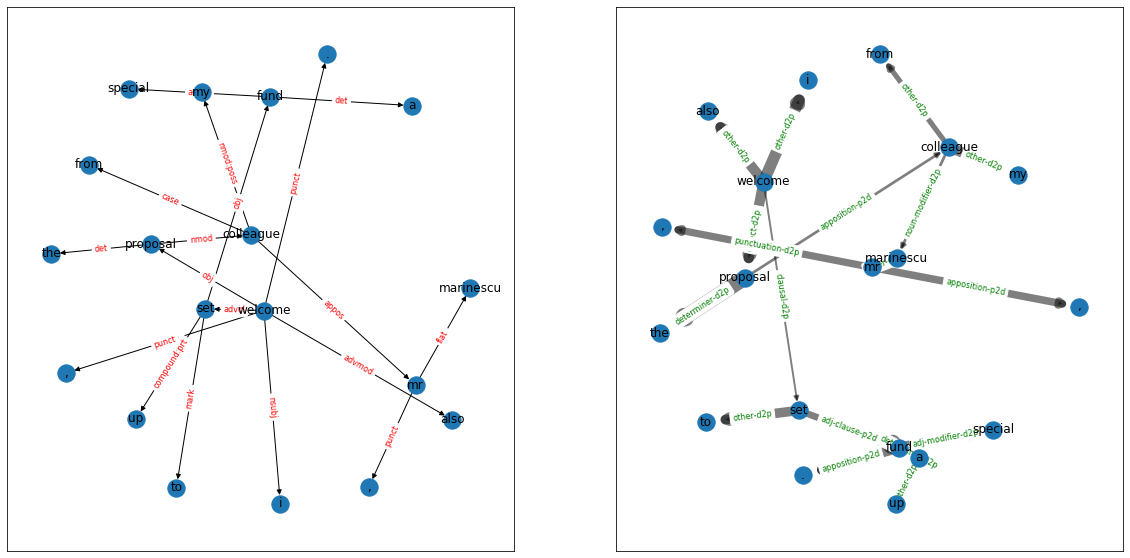

In [363]:
pred, gold  = multigraph_aborescene(1)

In [364]:
(np.array(list(map(int,gold.ravel()!='no edge')))*np.array(list(map(int,pred.ravel()!='no edge')))).sum()

13

In [356]:
np.array(list(map(int,gold.ravel()!='no edge'))).sum()

18

In [347]:
np.sum(pred != 'no edge', axis=0)

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [348]:
np.sum(pred != 'no edge', axis=1)

array([0, 1, 3, 0, 2, 1, 0, 1, 1, 0, 2, 2, 0, 1, 0, 0, 0, 4, 0])

In [349]:
np.sum(gold != 'no edge', axis=1)

array([0, 0, 6, 0, 2, 0, 0, 3, 0, 2, 0, 0, 0, 3, 0, 0, 0, 2, 0])

In [350]:
np.sum(gold != 'no edge', axis=0)

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [338]:
cmlabs = list(set(pred.ravel()).union(set(gold.ravel())))
# cmlabs.remove('no edge')
print_cm(confusion_matrix(pred.ravel(),gold.ravel(),cmlabs), cmlabs)


            adj-cla determi adj-mod object- punctua subject adv-mod noun-mo compoun apposit other-d i objec adv-cla no edge 
    adj-cla     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     1.0 
    determi     0.0     2.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0 
    adj-mod     0.0     0.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0 
    object-     0.0     0.0     0.0     2.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0 
    punctua     0.0     0.0     0.0     0.0     2.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     1.0 
    subject     0.0     0.0     0.0     0.0     0.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0 
    adv-mod     0.0     0.0     0.0     0.0     0.0     0.0     1.0     0.0     0.0     0.0     1.0     0.0     0.0     0.0 


## UDAPI

In [135]:
from udapi.core.document import Document
from udapi.block.read.conllu import Conllu

In [140]:

doc = Document()
doc.load_conllu(conllu_file_name)

In [146]:
b.bundle_id

'5'

In [153]:
b.get_tree().zone

''